In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report
import plotly.graph_objects as go
from sklearn.decomposition import PCA

In [ ]:
df = pd.read_csv("KDDTrain.csv")
df1 = pd.read_csv("KDDTest.csv")

In [ ]:
df.tail()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.0,1.00,1.0,0.00,0.0,anomaly
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.0,0.00,0.0,0.00,0.0,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.0,0.72,0.0,0.01,0.0,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.0,1.00,1.0,0.00,0.0,anomaly
125972,0,tcp,ftp_data,SF,151,0,0,0,0,0,...,77,0.30,0.03,0.30,0.0,0.00,0.0,0.00,0.0,normal


In [ ]:
class_vs_protocol = pd.crosstab(df["class"], df["protocol_type"])
class_vs_protocol

protocol_type,icmp,tcp,udp
class,,,
anomaly,6982,49089,2559
normal,1309,53600,12434


In [ ]:
df.isna().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [ ]:
#df = df.drop_duplicates()
#print(f"Number of duplicate rows: {df.duplicated().sum()}")

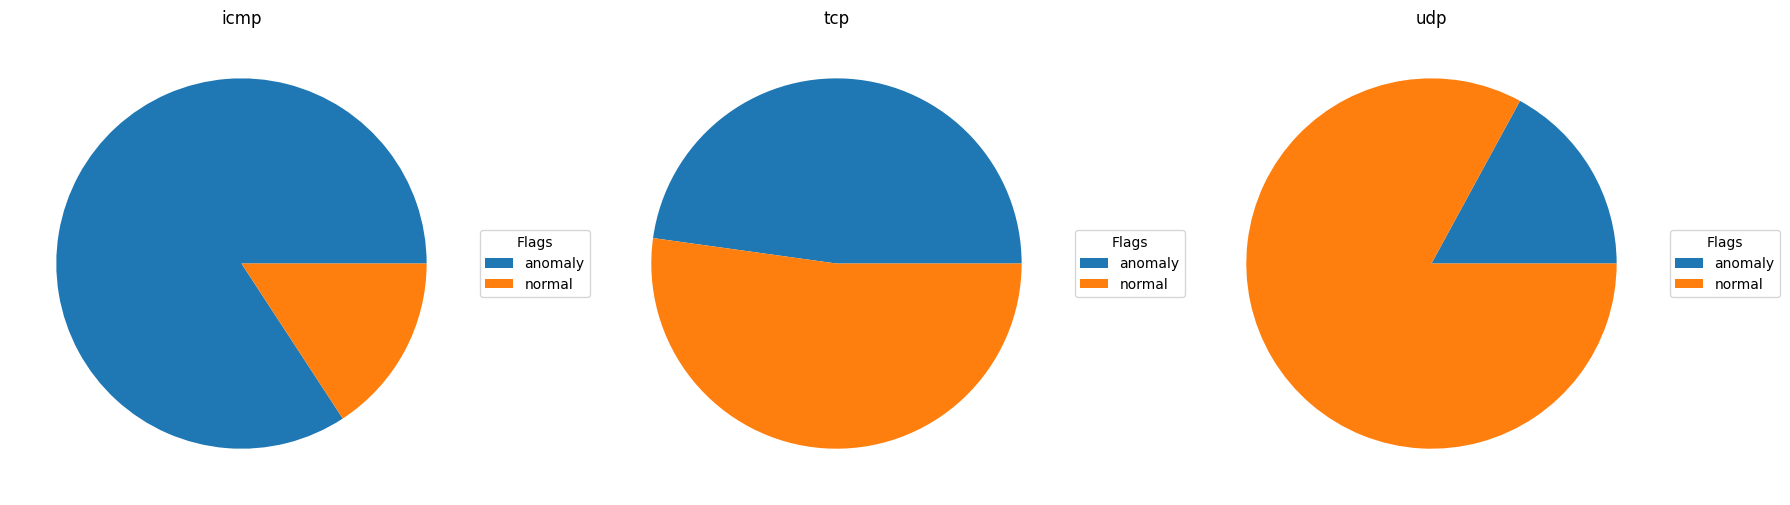

In [ ]:
import itertools
# helper function for drawing mulitple charts.
def bake_pies(data_list,labels):
    list_length = len(data_list)

    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}

    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)
     # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list):

        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)

        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        # build the legend
        axs[count].legend(wedges, data_set.index,title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])

    return axs
    # get the series for each protocol
icmp_attacks = class_vs_protocol.icmp
tcp_attacks = class_vs_protocol.tcp
udp_attacks = class_vs_protocol.udp
# create the charts
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
plt.show()

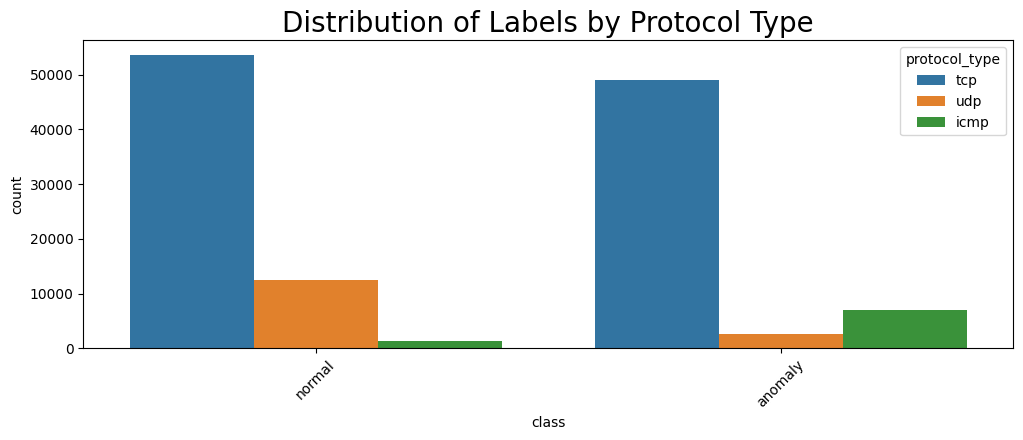

In [ ]:
plt.figure(figsize=(12, 4))
sns.countplot(x='class', data=df, hue='protocol_type')
plt.xticks(rotation=45)
plt.title('Distribution of Labels by Protocol Type', fontdict={'fontsize': 20})
plt.show()

<Axes: >

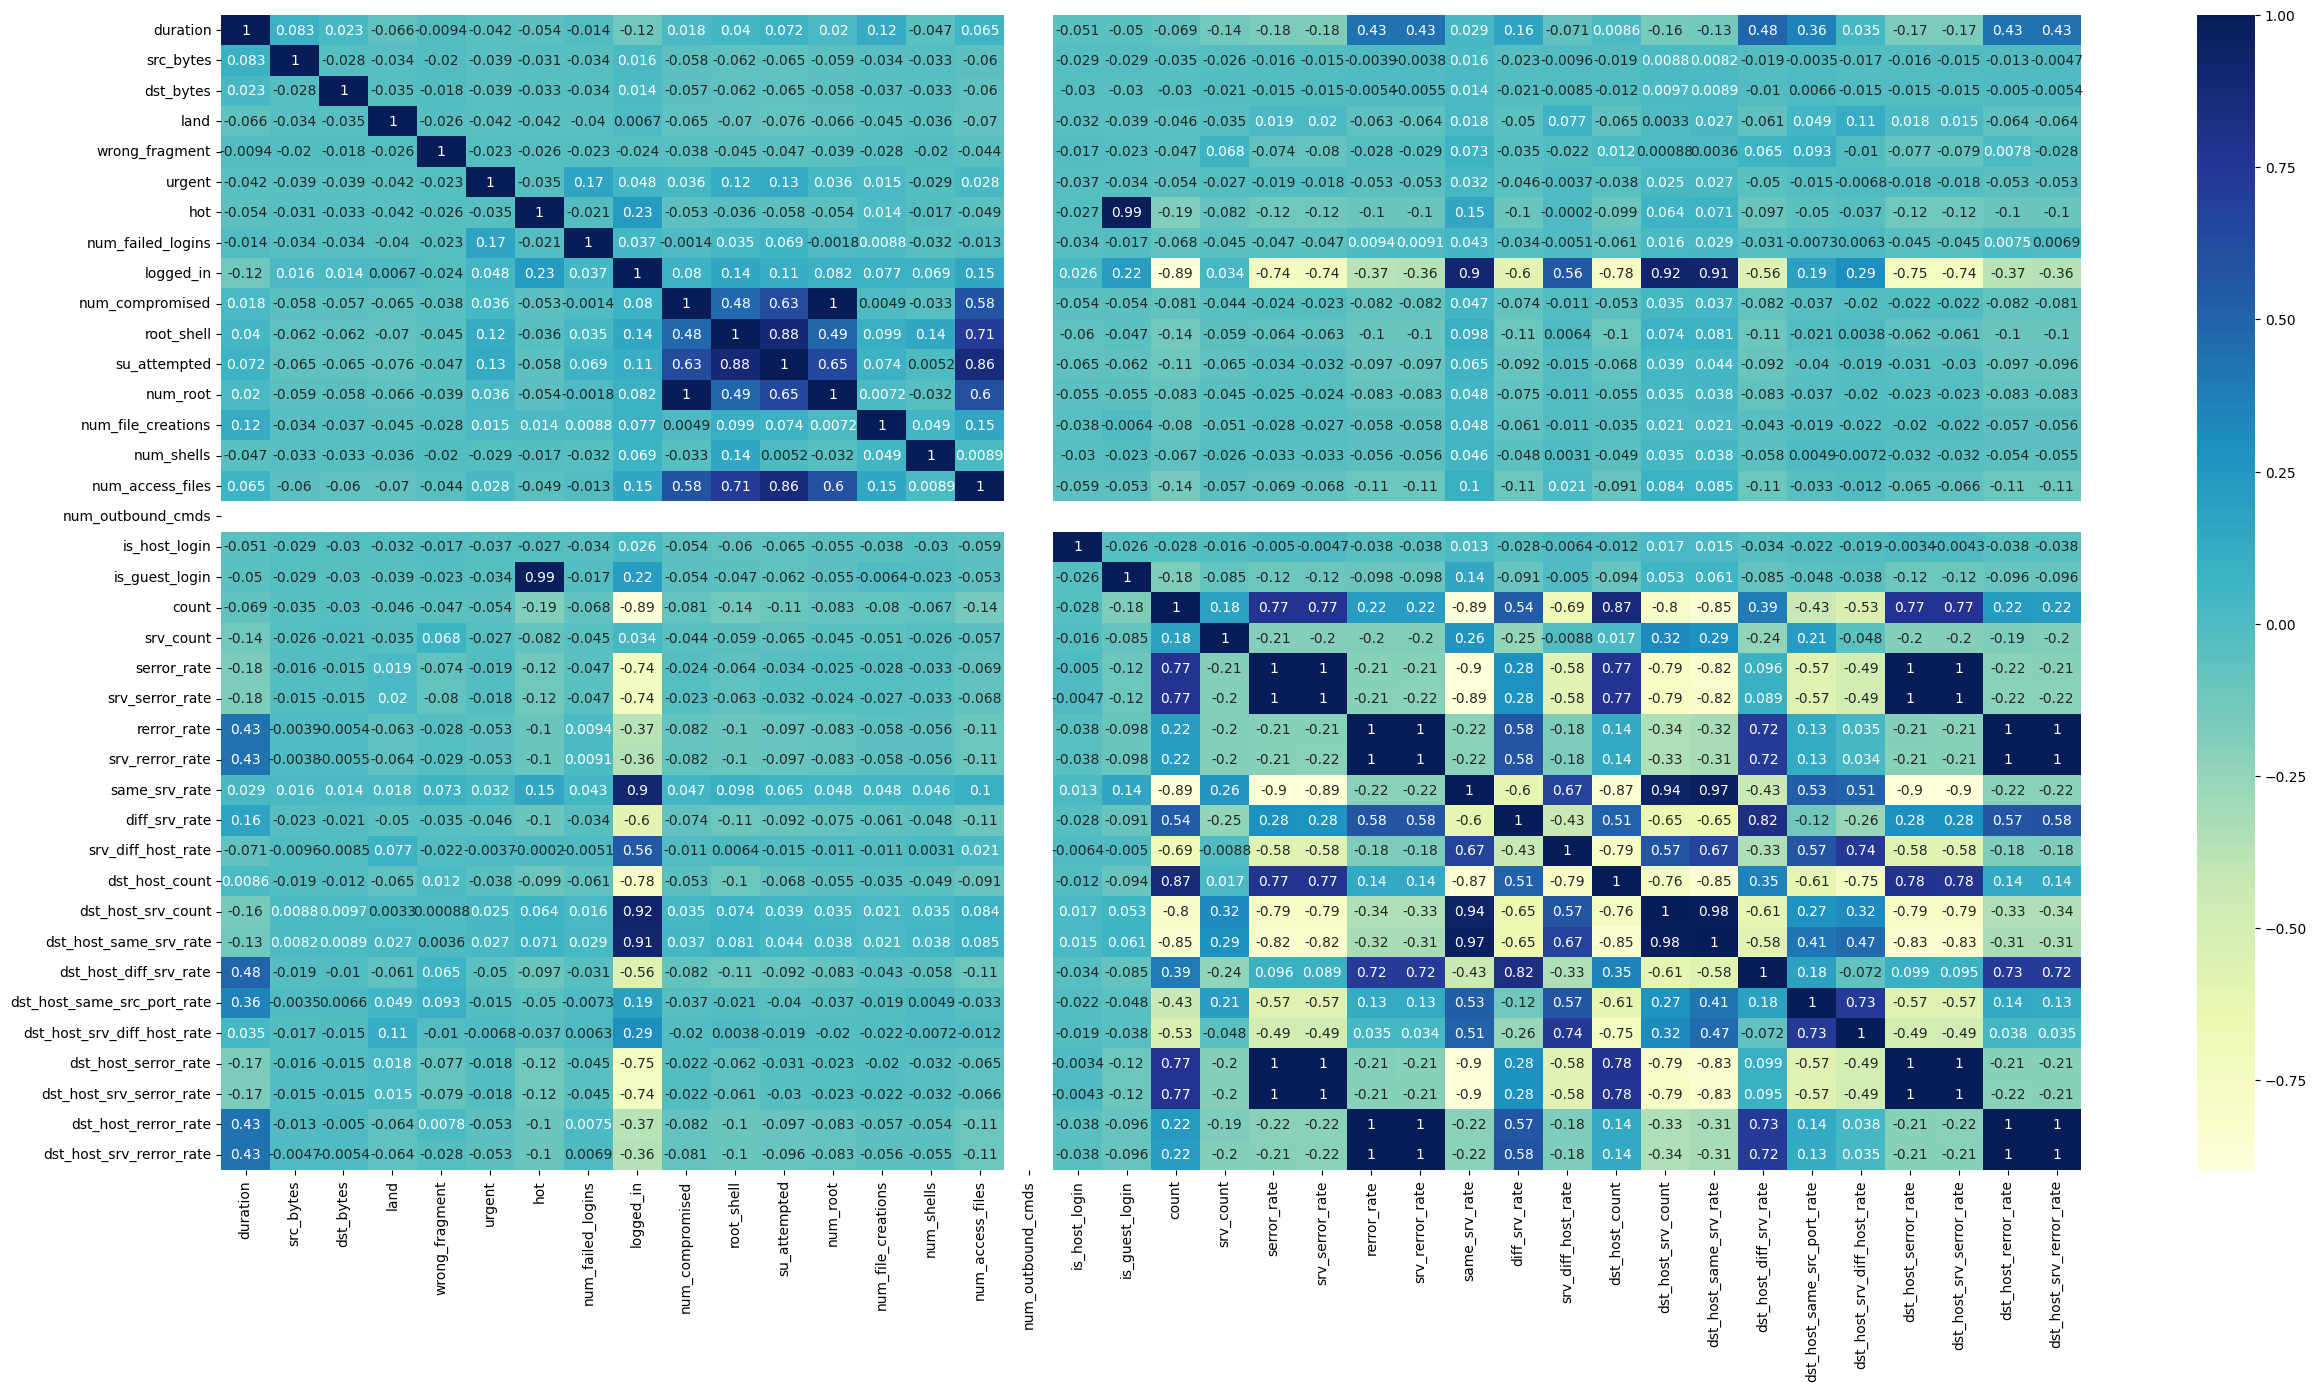

In [ ]:
numeric_columns = df.select_dtypes(include=['number']).columns
corr_matrix = df[numeric_columns].corr()
plt.figure(figsize=(30,15))
sns.heatmap(corr_matrix.corr(), annot=True, cmap="YlGnBu")

In [ ]:
#checking for outliers
num_df = df.select_dtypes(include=['float64', 'int64']).columns
outlier_counts = {}
for col in num_df:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[col][(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_counts[col] = len(outliers)
a=outlier_counts

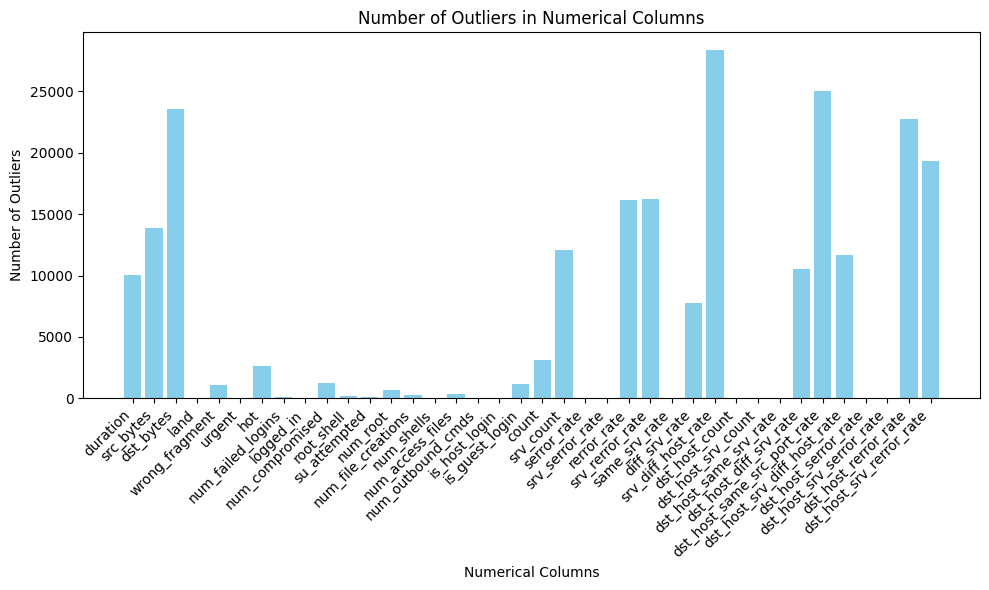

In [ ]:
# visualizing the result of the outliers
columns = list(a.keys())
outlier_counts_values = list(a.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(columns, outlier_counts_values, color='skyblue')
plt.title('Number of Outliers in Numerical Columns')
plt.xlabel('Numerical Columns')
plt.ylabel('Number of Outliers')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


## **DATA PREP**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Assuming df is your original dataframe

# Separate the target variable
y = df['class']
df = df.drop(['class'], axis=1)

# Separate numerical and categorical features
num_df = df.select_dtypes(include=['float64', 'int64']).copy()
cat_df = df.select_dtypes(include=['object']).copy()



# Categorical boolean mask
categorical_feature_mask = cat_df.dtypes == object
# filter categorical columns using mask and turn it into a list
categorical_cols = cat_df.columns[categorical_feature_mask].tolist()

# Encode categorical features
le = LabelEncoder()
cat_df[categorical_cols] = cat_df[categorical_cols].apply(lambda col: le.fit_transform(col))

# Reset indices before applying RobustScaler
num_df.reset_index(drop=True, inplace=True)
cat_df.reset_index(drop=True, inplace=True)

# Scale numerical features using RobustScaler
scaler = StandardScaler()
num_df_scaled = pd.DataFrame(scaler.fit_transform(num_df), columns=num_df.columns)

# Concatenate numerical and encoded categorical features
result_df = pd.concat([cat_df, num_df_scaled], axis=1)
result_df


,protocol_type,service,flag,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,1,20,9,-0.110249,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.324063,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387
1,2,44,9,-0.110249,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,0.734343,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387
2,1,49,5,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,0.734343,-0.809857,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387
3,1,24,9,-0.110249,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.533670,1.258754,1.066401,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084
4,1,24,9,-0.110249,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,0.734343,1.258754,1.066401,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,1,49,5,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,0.734343,-0.818890,-0.938287,-0.121485,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387
125969,2,49,9,-0.107178,-0.007744,-0.004883,-0.014089,-0.089486,-0.007736,-0.095076,...,0.734343,1.159389,0.977304,-0.386146,-0.447834,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387
125970,1,54,9,-0.110249,-0.007382,-0.004823,-0.014089,-0.089486,-0.007736,-0.095076,...,0.734343,-0.773724,-0.893738,-0.121485,-0.480197,-0.289103,0.979238,-0.624871,-0.355014,-0.376387
125971,1,30,5,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,0.734343,-0.972455,-1.094207,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387


# **VARIANCE THRESHOLD**

In [ ]:
from sklearn.feature_selection import VarianceThreshold

var_thr = VarianceThreshold(threshold=0.01)
var_thr.fit(result_df)

VarianceThreshold(threshold=0.01)

In [ ]:
supp = var_thr.get_support()

concol = [c for c in result_df.columns if c not in result_df.columns[supp]]

In [ ]:
for f in concol:
    print(f)

num_outbound_cmds


In [ ]:
our_result_df = result_df.copy()
for f in concol:
    del our_result_df[f]

In [ ]:
our_result_df

,protocol_type,service,flag,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,1,20,9,-0.110249,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.324063,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387
1,2,44,9,-0.110249,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,0.734343,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387
2,1,49,5,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,0.734343,-0.809857,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387
3,1,24,9,-0.110249,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.533670,1.258754,1.066401,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084
4,1,24,9,-0.110249,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,0.734343,1.258754,1.066401,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,1,49,5,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,0.734343,-0.818890,-0.938287,-0.121485,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387
125969,2,49,9,-0.107178,-0.007744,-0.004883,-0.014089,-0.089486,-0.007736,-0.095076,...,0.734343,1.159389,0.977304,-0.386146,-0.447834,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387
125970,1,54,9,-0.110249,-0.007382,-0.004823,-0.014089,-0.089486,-0.007736,-0.095076,...,0.734343,-0.773724,-0.893738,-0.121485,-0.480197,-0.289103,0.979238,-0.624871,-0.355014,-0.376387
125971,1,30,5,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,0.734343,-0.972455,-1.094207,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387


## **SMOTE** **AND** **PCA**

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
# Use SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(our_result_df, y)


In [ ]:
# Determine the number of components that explain a certain percentage of variance (e.g., 95%)
pca = PCA()
X_pca = pca.fit_transform(X_train_smote)

target_variance_ratio = 0.95
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
num_components = (cumulative_variance_ratio < target_variance_ratio).sum() + 1

# Apply PCA again with the determined number of components
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_train_smote)

# Display the features that remained after PCA
features_after_pca = [f'PC{i+1}' for i in range(num_components)]
df_pca = pd.DataFrame(data=X_pca, columns=features_after_pca)

In [ ]:
num_components

8

## **GMM TRAIN**

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Create a GMM model
gmm = GaussianMixture(n_components=2, random_state=42)

# Fit the GMM model to the training data
gmm.fit(df_pca)

# Predict the cluster labels for each data point in the training data
train_predictions = gmm.predict(df_pca)

# Access the parameters learned by the GMM
means = gmm.means_
covariances = gmm.covariances_
weights = gmm.weights_

# Optionally, you can also compute the log-likelihood of the data given the model
log_likelihood = gmm.score(df_pca)

# Print the results or further analyze as needed
print("Cluster Labels:", train_predictions)
print("Means:", means)
print("Covariances:", covariances)
print("Weights:", weights)
print("Log-Likelihood:", log_likelihood)

Cluster Labels: [0 1 0 ... 0 1 0]
Means: [[-2.03399825 -0.64851042 -0.82895875 -0.04861745  0.02695221  0.11214426
  -0.11072432  0.10706914]
 [ 6.47963831  2.06593737  2.6407854   0.15487892 -0.08586073 -0.35725411
   0.35273065 -0.34108647]]
Covariances: [[[ 2.61808792e+02 -4.45491497e-01 -8.53339859e+00 -8.84933752e-01
    8.18945924e-01  3.29569040e+00 -2.55938324e+00  1.21463611e+00]
  [-4.45491497e-01  7.13582888e+00 -4.57379623e+00  2.78566238e-01
    2.63377937e-01 -3.12660581e-01  5.31979290e-01 -2.85887329e-01]
  [-8.53339859e+00 -4.57379623e+00  3.26887646e+00 -1.47541495e-01
    4.90734199e-02  1.43820519e-01 -1.43676834e-01  1.62665006e-01]
  [-8.84933752e-01  2.78566238e-01 -1.47541495e-01  1.63009128e-02
   -1.21340002e-02  3.08487001e-02  6.93917811e-02 -2.31232910e-02]
  [ 8.18945924e-01  2.63377937e-01  4.90734199e-02 -1.21340002e-02
    2.18545834e+00 -1.84834437e-01 -8.45738315e-02 -5.76487000e-02]
  [ 3.29569040e+00 -3.12660581e-01  1.43820519e-01  3.08487001e-02
 

In [ ]:
np.unique(train_predictions, return_counts=True)

(array([0, 1]), array([102583,  32103]))

In [ ]:
# Check the unique cluster labels assigned to the test dataset
unique_labels = set(train_predictions)
print(f'Unique Labels in Test Dataset: {unique_labels}')

# Evaluate the model on the test data
if len(unique_labels) > 1:
    test_silhouette_avg = silhouette_score(df_pca, train_predictions)
    print(f'Test Silhouette Score: {test_silhouette_avg:.2f}')

    test_calinski_score = calinski_harabasz_score(df_pca, train_predictions)
    print(f'Test Calinski-Harabasz Index: {test_calinski_score:.2f}')

    test_davies_bouldin = davies_bouldin_score(df_pca, train_predictions)
    print(f'Test Davies-Bouldin Index: {test_davies_bouldin:.2f}')
else:
    print("Error: The test dataset was assigned only a single cluster label.")

Unique Labels in Test Dataset: {0, 1}
Test Silhouette Score: 0.14
Test Calinski-Harabasz Index: 8069.60
Test Davies-Bouldin Index: 3.14


In [ ]:
y_numm = np.array([1 if e=="anomaly" else 0 for e in y])

In [ ]:
class_vs_protocol

protocol_type,icmp,tcp,udp
class,,,
anomaly,6982,49089,2559
normal,1309,53600,12434


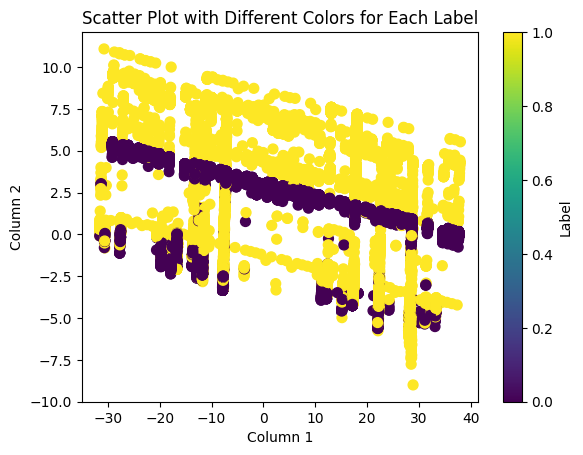

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a DataFrame with two numerical columns and a list of labels
labels = train_predictions

df = df_pca

# Scatter plot with different colors based on labels
plt.scatter(df['PC1'], df['PC2'], c=[label for label in labels], cmap='viridis', s=50)

# Add colorbar for better understanding of the color-code
cbar = plt.colorbar()
cbar.set_label('Label')

# Set labels and title
plt.xlabel('Column 1')
plt.ylabel('Column 2')
plt.title('Scatter Plot with Different Colors for Each Label')

plt.show()

## **DBSCAN**

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)  # You may need to adjust hyperparameters
train_dbscan_labels = dbscan.fit_predict(df_pca)


# Evaluate DBSCAN
train_dbscan_silhouette = silhouette_score(df_pca, train_dbscan_labels)
train_dbscan_calinski_harabasz = calinski_harabasz_score(df_pca, train_dbscan_labels)
train_dbscan_davies_bouldin = davies_bouldin_score(df_pca, train_dbscan_labels)



print("\nDBSCAN Training Set Metrics:")
print(f"Silhouette Score: {train_dbscan_silhouette}")
print(f"Calinski-Harabasz Index: {train_dbscan_calinski_harabasz}")
print(f"Davies-Bouldin Index: {train_dbscan_davies_bouldin}")




DBSCAN Training Set Metrics:
Silhouette Score: 0.2895898403264321
Calinski-Harabasz Index: 6008.189900163772
Davies-Bouldin Index: 1.379062329595839


### **KMEANS**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Assuming df_pca is your PCA-transformed training data
# Assuming df_pca1 is your PCA-transformed test data

# Specify the number of clusters (you can change this value)
num_clusters = 2

# Apply KMeans to the training data
kmeans_train = KMeans(n_clusters=num_clusters, random_state=42)
train_kmeans_labels = kmeans_train.fit_predict(df_pca)


# Evaluate KMeans on the training data
train_kmeans_silhouette = silhouette_score(df_pca, train_kmeans_labels)
train_kmeans_calinski_harabasz = calinski_harabasz_score(df_pca, train_kmeans_labels)
train_kmeans_davies_bouldin = davies_bouldin_score(df_pca, train_kmeans_labels)
print("KMeans Training Set Metrics:")
print(f"Silhouette Score: {train_kmeans_silhouette}")
print(f"Calinski-Harabasz Index: {train_kmeans_calinski_harabasz}")
print(f"Davies-Bouldin Index: {train_kmeans_davies_bouldin}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans Training Set Metrics:
Silhouette Score: 0.6873119579947273
Calinski-Harabasz Index: 450040.23087671725
Davies-Bouldin Index: 0.46497405062457303


### **HAC**

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Assuming df_pca is your PCA-transformed training data
# Assuming df_pca1 is your PCA-transformed test data

# Specify the number of clusters (you can change this value)
num_clusters = 2

# Apply Agglomerative Clustering to the training data
hac_train = AgglomerativeClustering(n_clusters=num_clusters)
train_hac_labels = hac_train.fit_predict(df_pca)

# Assign clusters to the test data without re-fitting the model
# test_hac_labels = hac_train.fit_predict(df_pca1)

# Evaluate Agglomerative Clustering on the training data
train_hac_silhouette = silhouette_score(df_pca, train_hac_labels)
train_hac_calinski_harabasz = calinski_harabasz_score(df_pca, train_hac_labels)
train_hac_davies_bouldin = davies_bouldin_score(df_pca, train_hac_labels)

# Evaluate Agglomerative Clustering on the test data (if needed)
# test_hac_silhouette = silhouette_score(df_pca1, test_hac_labels)
# test_hac_calinski_harabasz = calinski_harabasz_score(df_pca1, test_hac_labels)
# test_hac_davies_bouldin = davies_bouldin_score(df_pca1, test_hac_labels)

print("\nHierarchical Agglomerative Clustering Training Set Metrics:")
print(f"Silhouette Score: {train_hac_silhouette}")
print(f"Calinski-Harabasz Index: {train_hac_calinski_harabasz}")
print(f"Davies-Bouldin Index: {train_hac_davies_bouldin}")

# Uncomment the following lines if you want to print test set metrics
# print("\nHierarchical Agglomerative Clustering Test Set Metrics:")
# print(f"Silhouette Score: {test_hac_silhouette}")
# print(f"Calinski-Harabasz Index: {test_hac_calinski_harabasz}")
# print(f"Davies-Bouldin Index: {test_hac_davies_bouldin}")


## Test

## **data prep**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Assuming df is your original dataframe

# Separate the target variable
y1 = df1['class']
df1 = df1.drop(['class'], axis=1)

# Separate numerical and categorical features
num_df1 = df1.select_dtypes(include=['float64', 'int64']).copy()
cat_df1 = df1.select_dtypes(include=['object']).copy()



# Categorical boolean mask
categorical_feature_mask1 = cat_df1.dtypes == object
# filter categorical columns using mask and turn it into a list
categorical_cols1 = cat_df1.columns[categorical_feature_mask1].tolist()

# Encode categorical features
le = LabelEncoder()
cat_df1[categorical_cols1] = cat_df1[categorical_cols1].apply(lambda col: le.fit_transform(col))

# Reset indices before applying RobustScaler
num_df1.reset_index(drop=True, inplace=True)
cat_df1.reset_index(drop=True, inplace=True)

# Scale numerical features using RobustScaler
scaler = StandardScaler()
num_df_scaled1 = pd.DataFrame(scaler.fit_transform(num_df1), columns=num_df1.columns)

# Concatenate numerical and encoded categorical features
result_df1 = pd.concat([cat_df1, num_df_scaled1], axis=1)
result_df1

our_results_df1=result_df1.copy()
for c in concol :
    del our_results_df1[c]

# Apply PCA again with the determined number of components
X_pca = pca.transform(our_results_df1)

# Display the features that remained after PCA
features_after_pca = [f'PC{i+1}' for i in range(num_components)]
df_pca1 = pd.DataFrame(data=X_pca, columns=features_after_pca)




# **GMM TEST**

In [ ]:
test_predictions = gmm.predict(df_pca1)
test_predictions


In [ ]:

# Check the unique cluster labels assigned to the test dataset
unique_labels = set(test_predictions)
print(f'Unique Labels in Test Dataset: {unique_labels}')

# Evaluate the model on the test data
if len(unique_labels) > 1:
    test_silhouette_avg = silhouette_score(df_pca1, test_predictions)
    print(f'Test Silhouette Score: {test_silhouette_avg:.2f}')

    test_calinski_score = calinski_harabasz_score(df_pca1, test_predictions)
    print(f'Test Calinski-Harabasz Index: {test_calinski_score:.2f}')

    test_davies_bouldin = davies_bouldin_score(df_pca1, test_predictions)
    print(f'Test Davies-Bouldin Index: {test_davies_bouldin:.2f}')
else:
    print("Error: The test dataset was assigned only a single cluster label.")

In [ ]:
y

## **DBSCAN TEST**

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)  # You may need to adjust hyperparameters

test_dbscan_labels = dbscan.fit_predict(df_pca1)



test_dbscan_silhouette = silhouette_score(df_pca1, test_dbscan_labels)
test_dbscan_calinski_harabasz = calinski_harabasz_score(df_pca1, test_dbscan_labels)
test_dbscan_davies_bouldin = davies_bouldin_score(df_pca1, test_dbscan_labels)



print("\nDBSCAN Test Set Metrics:")
print(f"Silhouette Score: {test_dbscan_silhouette}")
print(f"Calinski-Harabasz Index: {test_dbscan_calinski_harabasz}")
print(f"Davies-Bouldin Index: {test_dbscan_davies_bouldin}")

# **KMEANS TEST**

In [ ]:
test_kmeans_labels = kmeans_train.predict(df_pca1)
# Evaluate KMeans on the test data
test_kmeans_silhouette = silhouette_score(df_pca1, test_kmeans_labels)
test_kmeans_calinski_harabasz = calinski_harabasz_score(df_pca1, test_kmeans_labels)
test_kmeans_davies_bouldin = davies_bouldin_score(df_pca1, test_kmeans_labels)


print("\nKMeans Test Set Metrics:")
print(f"Silhouette Score: {test_kmeans_silhouette}")
print(f"Calinski-Harabasz Index: {test_kmeans_calinski_harabasz}")
print(f"Davies-Bouldin Index: {test_kmeans_davies_bouldin}")
